## Matchbox (Caixinha de fósforo)

How many matches are inside the box? 

Load Libraries

In [1]:
#### Dependencies ####
####
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
#from manim import *
from scipy.io import wavfile as wav
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf
import os
import warnings

### Loading audios 

In [2]:
def load_audios(BASE_FOLDER,sr):
  files = os.listdir(BASE_FOLDER)
  raw_audio = []
  labels = []
  for f in files:
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      audio, _ = librosa.load(os.path.join(BASE_FOLDER, f),sr=sr, offset=0.2, duration=5)
    raw_audio.append(audio)
    name = f.split(".")[0]
    labels.append(int(name.split("-")[1]))
  return raw_audio,labels

#### Loading dataset. The name of the file is the number of matches inside the box recorded in the audio.

In [3]:
BASE_FOLDER1="Dataset/matchbox"
BASE_FOLDER2="Dataset/original"
sr = 44100
raw_audio,labels = load_audios(BASE_FOLDER1,sr)
raw_audio2,labels2 = load_audios(BASE_FOLDER2,sr)
raw_audio = raw_audio + raw_audio2
labels = labels + labels2

#### Initial visualization of data

In [6]:
def plot_magnitude_spectrum(signal, sr, title, f_ratio=1):
    X = np.fft.fft(signal)
    X_mag = np.absolute(X)

    plt.figure(figsize=(18, 5))

    f = np.linspace(0, sr, len(X_mag))
    f_bins = int(len(X_mag)*f_ratio)
    print(len(X_mag))
    print(f_bins)
    plt.plot(f[:f_bins], X_mag[:f_bins])
    plt.xlabel('Frequency (Hz)')
    plt.title(title)

def plot_raw_wave(signal, sr, title):
    plt.figure(figsize=(18, 5))
    plt.plot(np.linspace(0, len(signal)/sr, len(signal)), signal)
    plt.xlabel('Time (s)')
    plt.title(title)

In [7]:
BASE_FOLDER = BASE_FOLDER1

220500
73500


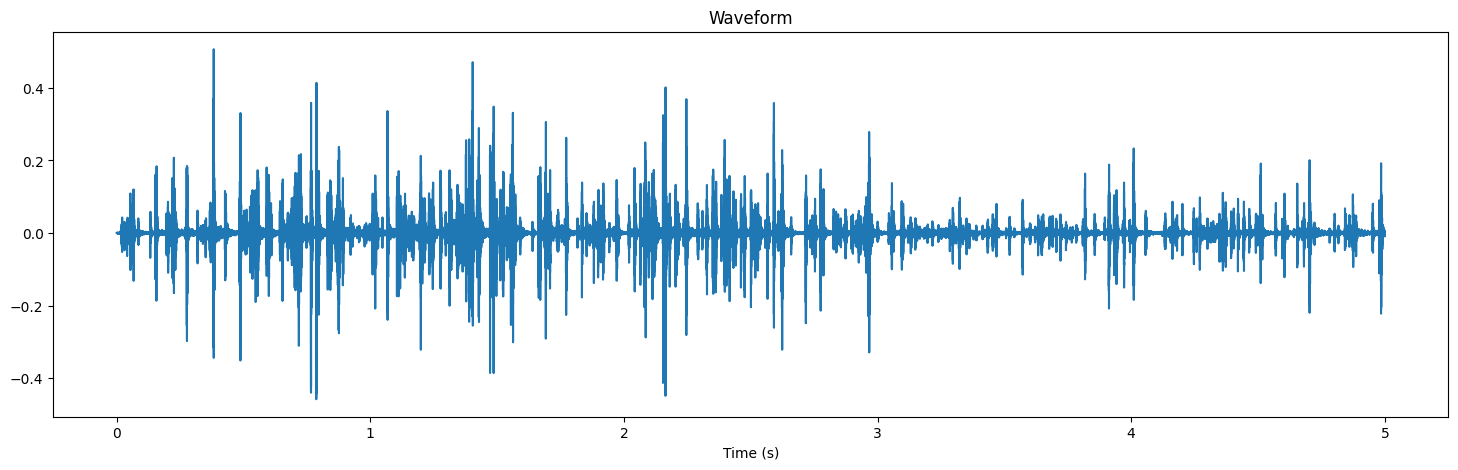

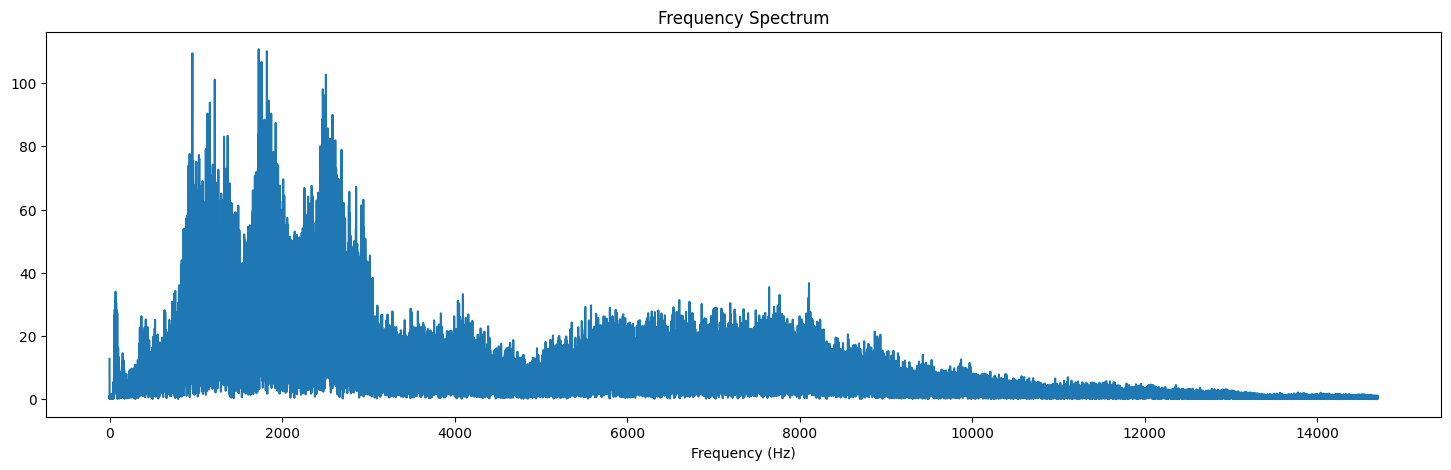

In [8]:
plot_raw_wave(raw_audio[0], sr, "Waveform")

plot_magnitude_spectrum(raw_audio[0], sr, "Frequency Spectrum", 1/3)


#### Obtain FFT and MFCC for an array of audios

In [32]:
def obtain_fft_mfcc(raw_audio):
  mfccs_processed = []
  ffts_mag = []
  len_fft = 85000
  for i in raw_audio:
    X = np.fft.fft(i)
    ffts_mag.append(np.absolute(X[:len_fft]))
    mfccs = librosa.feature.mfcc(y=i, sr=sr, n_mfcc=40)
    if mfccs.shape[1] == 431:
      mfccs_processed.append(mfccs)
      print(mfccs.shape)
  return ffts_mag,mfccs_processed

In [33]:
ffts_mag,mfccs_processed = obtain_fft_mfcc(raw_audio)


(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)
(40, 431)


AttributeError: 'list' object has no attribute 'shape'

In [48]:
mfccs_processed_t = np.array(mfccs_processed).transpose(0, 2, 1)
print(mfccs_processed_t.shape)

(2016, 431, 40)


In [49]:
df = pd.DataFrame(list(zip(raw_audio, ffts_mag, mfccs_processed_t, labels)),
               columns =['Raw_Audio', 'FFT', "MFCC", "Number_Matches"])

In [50]:
df.head()

,Raw_Audio,FFT,MFCC,Number_Matches
0,"[0.00019836426, 0.00019836426, 0.00019836426, ...","[12.773574829101562, 1.6305854215990776, 0.692...","[[-597.78076, 102.42551, -25.947884, 2.3400538...",1
1,"[0.00019836426, 0.00019836426, 0.00021362305, ...","[9.064697265625, 0.8087828525911768, 1.4386248...","[[-517.36584, 174.38364, -1.6867499, 2.0000575...",1
2,"[0.002105713, 0.0036773682, 0.0037231445, 0.00...","[10.047607421875, 1.8584604597480519, 0.424037...","[[-444.64285, 124.271576, -76.60603, 2.8250892...",1
3,"[-0.00012207031, -0.0001373291, -0.00012207031...","[9.905364990234375, 0.7286603023429553, 0.4653...","[[-586.50446, 118.85399, -20.58687, -8.842251,...",1
4,"[-0.0005340576, -0.0005340576, -0.00050354004,...","[9.03887939453125, 0.16227949459898, 0.5772629...","[[-438.20975, 165.77432, -22.415504, 34.77472,...",1


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Raw_Audio       2016 non-null   object
 1   FFT             2016 non-null   object
 2   MFCC            2016 non-null   object
 3   Number_Matches  2016 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 63.1+ KB


#### Define the input and labels


In [52]:
X = np.array(df.MFCC.tolist())
y = np.array(df.Number_Matches.tolist())

In [53]:
np.shape(X)

(2016, 431, 40)

In [54]:
seed = np.random.seed(20) 

#### Split the data for training and testing

In [55]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)

In [56]:
print(x_train.shape)

(1612, 431, 40)


In [57]:
y_test

array([ 26,  18,   6,  35,  70,   6,  10,  16,   6,   2,  13,  60, 100,
        26,  10,  35,  26, 120,  30,  45,  50,   4,  24, 110, 140,   7,
         9,  70,   8,  16, 130,  30, 130, 150,  14,  14,  11, 150,   1,
       150, 120,  12,   1, 110,  16,  80,  35,   5, 110,   4,   4,  35,
        70,  15,   8,  18, 140, 110, 100,  22,   2,  90,  28,  24,  55,
        70,   3,  14,  40,  26,  19,  50,  55,  15,  20,  18,   3,  10,
         7,  14,   9,  22,  15, 140,  19,  20,   5,  17,  80, 150,  45,
        14,  28,  45, 100,   8, 130,  18,   5,   4,  11,   6, 130, 150,
         7,  20,   5,   3,   7,   6,  65,  70,  10,  17,  28,  28,  26,
        10,   3, 120, 130,   4,  14, 150,  35,  11,  19,  80,  22,   8,
        18,  40,   5,  22,  55,   2, 100,   5,   6,  35,   9,  60,  55,
        28,  13,   8,  50,   9,  70,   3,  14,  20,  50,  13,  18,  19,
        24,  19,  15,   2,  15,   5, 120,  30,  11,  60,  65,  18, 110,
        65,  18, 150, 130,  11,  55,   9,   1,  80, 140, 150,  1

DNN Model

In [66]:
def build_model_MFCC():
  model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(431, 40)),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1)
    ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004)

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model_MFCC = build_model_MFCC();
model_MFCC.summary()

c:\Users\gugu1\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 429, 64)        │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 427, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 425, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,265 (512.75 KB)

 Trainable params: 131,265 (512.75 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [67]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime
num_epochs = 200
num_batch_size = 32
history_model_MFCC = model_MFCC.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,validation_data=(x_test, y_test), verbose=1)

Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 31.6419 - mae: 31.6386 - mse: 2064.1230 - val_loss: 29.9252 - val_mae: 29.8087 - val_mse: 1755.2722
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 29.0269 - mae: 29.0251 - mse: 1845.1477 - val_loss: 28.0541 - val_mae: 27.8901 - val_mse: 1770.4027
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 28.0968 - mae: 28.0976 - mse: 1727.1903 - val_loss: 29.2994 - val_mae: 29.0310 - val_mse: 1981.7290
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 28.8240 - mae: 28.8185 - mse: 1738.1438 - val_loss: 26.8082 - val_mae: 26.6522 - val_mse: 1522.8893
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 27.5723 - mae: 27.5647 - mse: 1594.8837 - val_loss: 26.8299 - val_mae: 26.6476 - val_mse: 1744.3472
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 27.0713 - mae: 27.0739 - mse: 1615.6763 - val_loss: 26.7617 - val_mae: 26.5539 - val_mse: 1773.5613
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 1

#### Results of training 

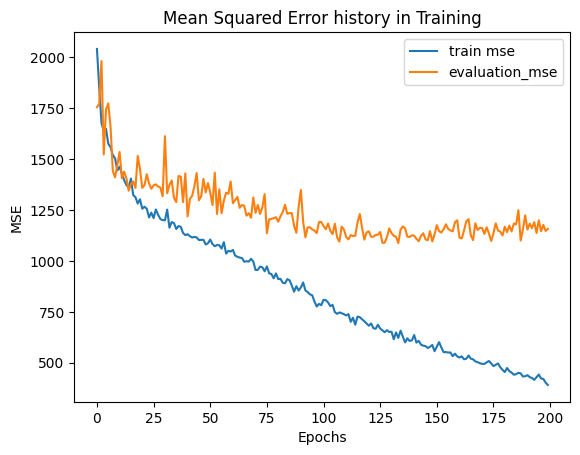

In [79]:

plt.plot(history_model_MFCC.history['mse'], label='train mse');
plt.plot(history_model_MFCC.history['val_mse'], label='evaluation_mse');
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Mean Squared Error history in Training")
plt.legend()
plt.show()

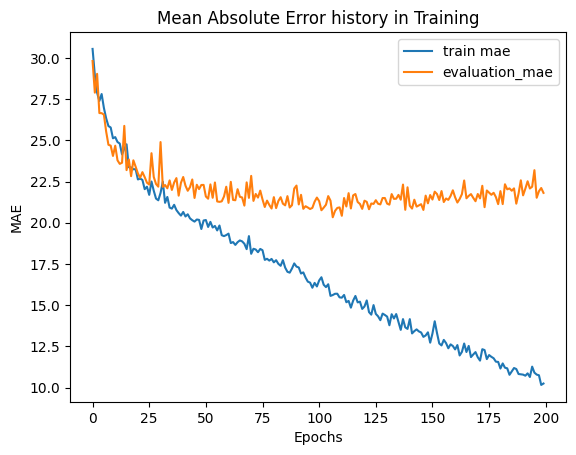

In [69]:
plt.plot(history_model_MFCC.history['mae'], label='train mae');
plt.plot(history_model_MFCC.history['val_mae'], label='evaluation_mae');
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Mean Absolute Error history in Training")
plt.legend()
plt.show()

In [70]:
loss, mae, mse = model_MFCC.evaluate(x_test, y_test)
loss, mae, mse

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.4080 - mae: 22.3821 - mse: 1199.3225 


(21.993927001953125, 21.812570571899414, 1157.3399658203125)

In [78]:
print(f"Confidence in prediction: {(1- (mae/140))*100}%")

Confidence in prediction: 84.41959244864327%


#### Results of precision

In [80]:
def moving_window(y_test, y_pred, size):
  idx_sort = np.argsort(y_test)
  y_test = y_test[idx_sort]
  y_pred = y_pred[idx_sort]
  mov_test = []
  mov_pred = []
  for i in range(len(y_test) - (size-1)):
    mov_test.append(y_test[i:i+size])
    mov_pred.append(y_pred[i:i+size])
  return mov_test,mov_pred

In [81]:
def local_MSE(yg_test,yg_pred):
  l_MSE = []
  for idx, m_t in enumerate(yg_test):
    l_MSE.append(mean_squared_error(m_t,yg_pred[idx]))
  return np.array(l_MSE)

def local_MAE(yg_test,yg_pred):
  l_MSE = []
  for idx, m_t in enumerate(yg_test):
    l_MSE.append(mean_absolute_error(m_t,yg_pred[idx]))
  return np.array(l_MSE)


In [82]:
def own_grouping(y_test, y_pred, o_sz_group, sz_split, grouping):
  idx_sort = np.argsort(y_test)
  y_test = y_test[idx_sort]
  y_pred = y_pred[idx_sort]
  yg_test = []
  yg_pred = []
  size_group = int(o_sz_group*sz_split)
  idx_prev = 0
  for i in grouping:
    idx_n = i*size_group
    yg_test.append(y_test[idx_prev:idx_n])
    yg_pred.append(y_pred[idx_prev:idx_n])
    idx_prev = idx_n
  return yg_test,yg_pred

In [95]:
def moving_window_average(array,size):
  #idx_sort = np.argsort(array)
  #array = array[idx_sort]
  mov_avg_array = []
  for i in range(len(array) - (size-1)):
    #print(array[i:i+size])
    mov_avg_array.append(np.mean(array[i:i+size]))

  return mov_avg_array

In [84]:
result = model_MFCC.predict(x_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [101]:
grouping = [20, 25, 33, 41]
ygo_test,ygo_pred = own_grouping(y_test, result, 25, 0.2, grouping)

In [102]:
def own_grouping2(y_test, y_pred, o_sz_group, sz_split):
  idx_sort = np.argsort(y_test)
  y_test = y_test[idx_sort]
  y_pred = y_pred[idx_sort]
  yg_test = []
  yg_pred = []
  size_group = int(o_sz_group*sz_split)
  idx_prev = 0
  for i in range(size_group,len(y_test)+1,size_group):
    idx_n = i
    yg_test.append(y_test[idx_prev:idx_n])
    yg_pred.append(y_pred[idx_prev:idx_n])
    idx_prev = idx_n
  return yg_test,yg_pred

In [103]:
ygo_test2,ygo_pred2 = own_grouping2(y_test, result, 50, 0.2)

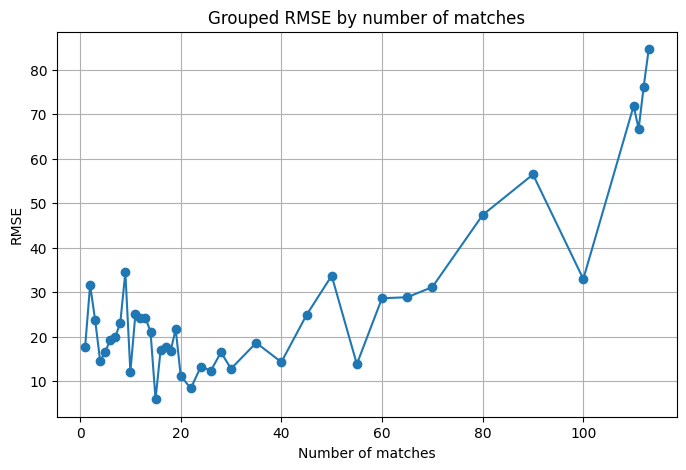

In [104]:
grouped_MSE2 = local_MSE(ygo_test2, ygo_pred2)
grouped_RMSE2 = np.sqrt(grouped_MSE2)

x = np.concatenate([np.arange(1, 21, 1), np.arange(22, 31, 2), np.arange(35, 71, 5), np.arange(80, 120, 10)])

if len(x) > len(grouped_RMSE2):
    x = x[:len(grouped_RMSE2)]
elif len(x) < len(grouped_RMSE2):
    x = np.concatenate([x, np.arange(x[-1] + 1, x[-1] + 1 + (len(grouped_RMSE2) - len(x)))])

plt.figure(num=1, figsize=(8, 5))
plt.plot(x, grouped_RMSE2, '-o')
plt.xlabel("Number of matches")
plt.ylabel("RMSE")
plt.title("Grouped RMSE by number of matches")
plt.grid()
plt.show()

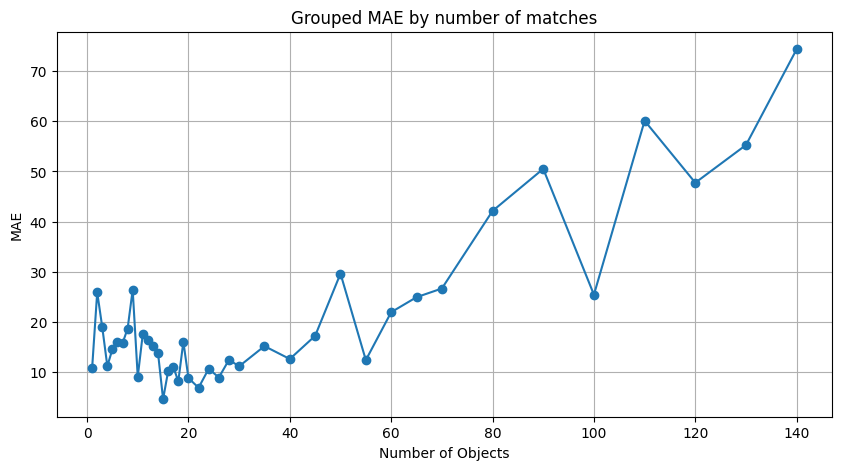

In [107]:
grouped_MAE2 = local_MAE(ygo_test2, ygo_pred2)
x = np.concatenate([np.arange(1, 21, 1), np.arange(22, 31, 2), np.arange(35, 71, 5), np.arange(80, 151, 10)])

x = x[:len(grouped_MAE2)]

plt.figure(num=1, figsize=(10, 5))
plt.plot(x, grouped_MAE2, '-o')
plt.xlabel("Number of Objects")
plt.ylabel("MAE")
plt.title("Grouped MAE by number of matches")
plt.grid()
plt.show()